In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/30-days-of-ml/sample_submission.csv
/kaggle/input/30-days-of-ml/train.csv
/kaggle/input/30-days-of-ml/test.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

from xgboost import XGBRegressor

from tqdm.notebook import tqdm

In [3]:
df_train = pd.read_csv('/kaggle/input/30-days-of-ml/train.csv')

In [4]:
df_train.head()

,id,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,B,B,B,C,B,B,A,E,C,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,2,B,B,A,A,B,D,A,F,A,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,3,A,A,A,C,B,D,A,D,A,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,4,B,B,A,C,B,D,A,E,C,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,6,A,A,A,C,B,D,A,E,A,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


In [5]:
df_train = df_train.drop(['id'], axis=1)
df_train.describe()

,cont0,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000
mean,0.527335,0.460926,0.490498,0.496689,0.491654,0.510526,0.467476,0.537119,0.498456,0.474872,0.474492,0.473216,0.494561,0.508273,8.241979
std,0.230599,0.214003,0.253346,0.219199,0.240074,0.228232,0.210331,0.218140,0.239920,0.218007,0.255949,0.222022,0.247292,0.222950,0.746555
min,-0.118039,-0.069309,-0.056104,0.130676,0.255908,0.045915,-0.224689,0.203763,-0.260275,0.117896,0.048732,0.052608,-0.074208,0.151050,0.140329
25%,0.405965,0.310494,0.300604,0.329783,0.284188,0.354141,0.342873,0.355825,0.332486,0.306874,0.276017,0.308151,0.289074,0.300669,7.742071
50%,0.497053,0.427903,0.502462,0.465026,0.390470,0.488865,0.429383,0.504661,0.439151,0.434620,0.459975,0.433812,0.422887,0.472400,8.191373
75%,0.668060,0.615113,0.647512,0.664451,0.696599,0.669625,0.573383,0.703441,0.606056,0.614333,0.691579,0.642057,0.714502,0.758447,8.728634
max,1.058443,0.887253,1.034704,1.039560,1.055424,1.067649,1.111552,1.032837,1.040229,0.982922,1.055960,1.071444,0.975035,0.905992,10.411992


In [6]:
df_train.columns

Index(['cat0', 'cat1', 'cat2', 'cat3', 'cat4', 'cat5', 'cat6', 'cat7', 'cat8',
       'cat9', 'cont0', 'cont1', 'cont2', 'cont3', 'cont4', 'cont5', 'cont6',
       'cont7', 'cont8', 'cont9', 'cont10', 'cont11', 'cont12', 'cont13',
       'target'],
      dtype='object')

# Converting Categorical to ordinal

In [7]:
for i in range(10):
    df_train['cat' + str(i)] = df_train['cat' + str(i)].astype('category')
    df_train['cat' + str(i)] = df_train['cat' + str(i)].cat.codes

df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 25 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   cat0    300000 non-null  int8   
 1   cat1    300000 non-null  int8   
 2   cat2    300000 non-null  int8   
 3   cat3    300000 non-null  int8   
 4   cat4    300000 non-null  int8   
 5   cat5    300000 non-null  int8   
 6   cat6    300000 non-null  int8   
 7   cat7    300000 non-null  int8   
 8   cat8    300000 non-null  int8   
 9   cat9    300000 non-null  int8   
 10  cont0   300000 non-null  float64
 11  cont1   300000 non-null  float64
 12  cont2   300000 non-null  float64
 13  cont3   300000 non-null  float64
 14  cont4   300000 non-null  float64
 15  cont5   300000 non-null  float64
 16  cont6   300000 non-null  float64
 17  cont7   300000 non-null  float64
 18  cont8   300000 non-null  float64
 19  cont9   300000 non-null  float64
 20  cont10  300000 non-null  float64
 21  cont11  30

In [8]:
df_train.head()

,cat0,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,...,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,target
0,1,1,1,2,1,1,0,4,2,13,...,0.400361,0.160266,0.310921,0.389470,0.267559,0.237281,0.377873,0.322401,0.869850,8.113634
1,1,1,0,0,1,3,0,5,0,14,...,0.533087,0.558922,0.516294,0.594928,0.341439,0.906013,0.921701,0.261975,0.465083,8.481233
2,0,0,0,2,1,3,0,3,0,5,...,0.650609,0.375348,0.902567,0.555205,0.843531,0.748809,0.620126,0.541474,0.763846,8.364351
3,1,1,0,2,1,3,0,4,2,10,...,0.668980,0.239061,0.732948,0.679618,0.574844,0.346010,0.714610,0.540150,0.280682,8.049253
4,0,0,0,2,1,3,0,4,0,13,...,0.686964,0.420667,0.648182,0.684501,0.956692,1.000773,0.776742,0.625849,0.250823,7.972260


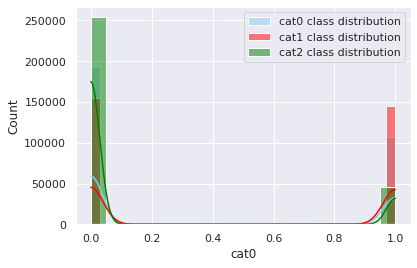

In [9]:
sns.set(style="darkgrid")
sns.histplot(data=df_train, x="cat0", color="skyblue", label="cat0 class distribution", kde=True)
sns.histplot(data=df_train, x="cat1", color="red", label="cat1 class distribution", kde=True)
sns.histplot(data=df_train, x="cat2", color="green", label="cat2 class distribution", kde=True)
plt.legend() 
plt.show()

<AxesSubplot:>

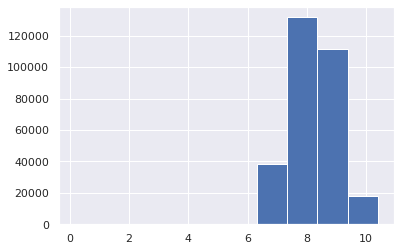

In [10]:
df_train.target.hist()

In [11]:
def evaluate_metrics(model, x, y):
    predictions = model.predict(x)
    rmse = mean_squared_error(y, predictions, squared=False)
    return rmse

In [12]:
y = df_train.target.values
df_train.drop(['target'], axis=1, inplace=True)
x = df_train.values

# Extreme Gradient Boosting (XGBoost) 

<h3> K cross validation </h3>
We're going to use K cross validation to evaluate the model

In [13]:
def evaluate_model(model):
    cv = RepeatedKFold(n_splits=10, n_repeats=1, random_state=1)
    scores = cross_val_score(model, x, y, scoring='neg_root_mean_squared_error', cv=cv, n_jobs=-1, error_score='raise')
    return scores

<h3> 1 - Testing different number of estimators </h3>

estimators = [10,50,100,1000,5000]

In [14]:
def get_models_n_estimators():
    models = dict()
    trees = [10, 50, 100, 500, 1000, 5000]
    for n in trees:
        models[str(n)] = XGBRegressor(n_estimators=n)
    return models

In [15]:
models = get_models_n_estimators()

K cross validation - 10 splits

In [16]:
# results, names = list(), list()
# for name, model in tqdm(models.items()):
#     scores = evaluate_model(model)
#     results.append(scores)
#     names.append(name)
#     print('>%s %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

Not K cross

In [17]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

In [18]:
models = get_models_n_estimators()
results, names = list(), list()
i = 0

for name, model in tqdm(models.items()):
    model.fit(x_train, y_train, verbose=True)
    scores = evaluate_metrics(model, x_test, y_test)
    results.append(scores)
    names.append(name)
    print('>%s %.3f' % (name, results[i]))
    i += 1

  0%|          | 0/6 [00:00<?, ?it/s]

>10 0.765
>50 0.724
>100 0.724
>500 0.734
>1000 0.744
>5000 0.775


<h3> 2 - Testing different max_depth </h3>

depth = [1..10]

In [19]:
def get_models_n_depths():
    models = dict()
    for i in range(1,11):
        models[str(i)] = XGBRegressor(n_estimators=50, max_depth=i)
    return models

In [20]:
models = get_models_n_depths()
results, names = list(), list()
i = 0

for name, model in tqdm(models.items()):
    model.fit(x_train, y_train, verbose=True)
    scores = evaluate_metrics(model, x_test, y_test)
    results.append(scores)
    names.append(name)
    print('>%s %.3f' % (name, results[i]))
    i += 1

  0%|          | 0/10 [00:00<?, ?it/s]

>1 0.735
>2 0.730
>3 0.727
>4 0.725
>5 0.724
>6 0.724
>7 0.726
>8 0.728
>9 0.733
>10 0.738


# 3 - Testing different subsamples

In [21]:
def get_models_subsamples():
    models = dict()
    for i in np.arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        models[key] = XGBRegressor(subsample=i)
    return models

In [22]:
models = get_models_subsamples()
results, names = list(), list()
i = 0

for name, model in tqdm(models.items()):
    model.fit(x_train, y_train, verbose=True)
    scores = evaluate_metrics(model, x_test, y_test)
    results.append(scores)
    names.append(name)
    print('>%s %.3f' % (name, results[i]))
    i += 1

  0%|          | 0/10 [00:00<?, ?it/s]

>0.1 0.759
>0.2 0.743
>0.3 0.737
>0.4 0.732
>0.5 0.730
>0.6 0.728
>0.7 0.727
>0.8 0.726
>0.9 0.725
>1.0 0.724


# 4 - Testing different learning rates

In [23]:
def get_models_lr():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = XGBRegressor(eta=r)
    return models

In [24]:
models = get_models_lr()
results, names = list(), list()
i = 0

for name, model in tqdm(models.items()):
    model.fit(x_train, y_train, verbose=True)
    scores = evaluate_metrics(model, x_test, y_test)
    results.append(scores)
    names.append(name)
    print('>%s %.3f' % (name, results[i]))
    i += 1

  0%|          | 0/5 [00:00<?, ?it/s]

>0.0001 7.702
>0.0010 7.045
>0.0100 2.929
>0.1000 0.724
>1.0000 0.767


# 5 - Testing different number of features

In [25]:
def get_models_nfeatures():
    models = dict()
    for i in np.arange(0.1, 1.1, 0.1):
        key = '%.1f' % i
        models[key] = XGBRegressor(colsample_bytree=i)
    return models

In [26]:
models = get_models_nfeatures()
results, names = list(), list()
i = 0

for name, model in tqdm(models.items()):
    model.fit(x_train, y_train, verbose=True)
    scores = evaluate_metrics(model, x_test, y_test)
    results.append(scores)
    names.append(name)
    print('>%s %.3f' % (name, results[i]))
    i += 1

  0%|          | 0/10 [00:00<?, ?it/s]

>0.1 0.721
>0.2 0.722
>0.3 0.722
>0.4 0.723
>0.5 0.723
>0.6 0.724
>0.7 0.723
>0.8 0.724
>0.9 0.724
>1.0 0.724


# Grid Search

Lets do a Grid search on some of the best parameters obtained above

In [27]:
params = {'n_estimators' : [50,100,200],
          'max_depth' : [5,6],
          'subsample' : [0.9,1.0],
          'eta' : [0.1, 0.12, 0.13],
          'colsample_bytree' : [0.1, 0.2, 0.3]
         }

In [28]:
metrics = ['neg_root_mean_squared_error']

In [29]:
grid_cv = GridSearchCV(XGBRegressor(), param_grid=params, scoring=metrics, verbose=1, refit='neg_root_mean_squared_error', return_train_score=False, n_jobs=-1)

In [30]:
result = grid_cv.fit(x, y)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 84.3min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 235.2min
[Parallel(n_jobs=-1)]: Done 540 out of 540 | elapsed: 307.3min finished


In [31]:
grid_cv.best_params_

{'colsample_bytree': 0.2,
 'eta': 0.12,
 'max_depth': 6,
 'n_estimators': 200,
 'subsample': 1.0}

In [32]:
model = XGBRegressor(n_estimators=200, eta=0.12, max_depth=6, subsample=1.0, colsample_bytree=0.2)

In [33]:
model.fit(x_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, eta=0.12, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.119999997, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
evaluate_metrics(model, x_test, y_test)

0.7197771911646221

In [35]:
model = XGBRegressor(n_estimators=200, eta=0.12, max_depth=6, subsample=1.0, colsample_bytree=0.2)

In [36]:
model.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, eta=0.12, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.119999997, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [37]:
df_test = pd.read_csv('/kaggle/input/30-days-of-ml/test.csv')

In [38]:
 for i in range(10):
    df_test['cat' + str(i)] = df_test['cat' + str(i)].astype('category')
    df_test['cat' + str(i)] = df_test['cat' + str(i)].cat.codes

In [39]:
ids = df_test['id'].values
df_test = df_test.drop(['id'], axis=1)

In [40]:
target = model.predict(df_test.values)

In [41]:
submission = pd.DataFrame({'id' : ids, 'target' : target})

In [42]:
submission.head()

,id,target
0,0,8.013986
1,5,8.293573
2,15,8.390730
3,16,8.460368
4,17,8.172173


In [43]:
submission.to_csv('submission.csv', index=False)

<h3>Lets try a different number of estimators. Something between 200 and 300</h3>

In [44]:
params = {'n_estimators' : [50,100,200,210,220,230,240,250,260,270,280,290,300,310]}
metrics = ['neg_root_mean_squared_error']
grid_cv = GridSearchCV(XGBRegressor(eta=0.12, max_depth=6, subsample=1.0, colsample_bytree=0.2), param_grid=params, scoring=metrics, verbose=1, refit='neg_root_mean_squared_error', return_train_score=False, n_jobs=-1)

In [45]:
grid_cv.fit(x, y)

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 86.1min finished


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=0.2,
                                    eta=0.12, gamma=None, gpu_id=None,
                                    importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=6, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=1.0,
                                    tree_method=None, validate_parameters=None,
 

In [46]:
print(grid_cv.best_score_)
print(grid_cv.best_params_)

-0.7197632604360361
{'n_estimators': 310}


In [47]:
model = XGBRegressor(n_estimators=310, eta=0.12, max_depth=6, subsample=1.0, colsample_bytree=0.2)

In [48]:
model.fit(x, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.2, eta=0.12, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.119999997, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=310, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
target = model.predict(df_test.values)

In [50]:
submission = pd.DataFrame({'id' : ids, 'target' : target})

In [51]:
submission.head()

,id,target
0,0,8.013052
1,5,8.303625
2,15,8.389752
3,16,8.470916
4,17,8.125373


In [52]:
submission.to_csv('submission.csv', index=False)